# Data Selection & Visualization

This notebook filters a large image/mask collection to keep only those with non-empty masks, uses a fixed random seed to reproducibly split them into 800/200/200 train/val/test sets, copies each image–mask pair into the `datasets/{split}/{images,masks}` folder structure, and renders quick overlay contact sheets for visual sanity checks.


#### Imports & paths
Load utilities (OS, random, file I/O, progress bars, imaging and plotting), set your working directory, point to your raw train/ images and masks/, and declare where you’ll later dump the split outputs and how many of each you want.

In [1]:
import os
import random
import shutil
from pathlib import Path
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

BASE_DIR     = Path.cwd()                     # …/glomeruli_segmentation/data_preprocess
PROJECT_DIR  = BASE_DIR.parent                # …/glomeruli_segmentation
DATASETS_DIR = PROJECT_DIR / "datasets"

SRC_IMG_DIR  = BASE_DIR / "train"
SRC_MASK_DIR = BASE_DIR / "masks"

# Now point each split at datasets/{split}/images and datasets/{split}/masks
OUT_IMG = {
    "train": DATASETS_DIR / "train" / "images",
    "val"  : DATASETS_DIR / "val"   / "images",
    "test" : DATASETS_DIR / "test"  / "images"
}
OUT_MASK = {
    "train": DATASETS_DIR / "train" / "masks",
    "val"  : DATASETS_DIR / "val"   / "masks",
    "test" : DATASETS_DIR / "test"  / "masks"
}

# make sure downstream mkdir calls use parents=True


# Number of samples for each split
N_TRAIN, N_VAL, N_TEST = 800, 200, 200
RANDOM_SEED = 42


#### Filter valid masks
Define has_valid_mask() to check that each PNG mask exists and isn’t empty, then build valid_imgs by keeping only those source images whose mask passes that test.

In [2]:
def has_valid_mask(img_path: Path, mask_dir: Path) -> bool:
    """
    Return True only if the corresponding mask PNG exists
    and contains at least one foreground pixel.
    """
    mask_path = mask_dir / f"{img_path.stem}.png"
    if not mask_path.exists():
        return False
    with Image.open(mask_path) as m:
        # If max pixel value is 0, the mask is completely black
        if m.getextrema()[1] == 0:
            return False
    return True

# Gather all source images and filter those with valid masks
all_images = sorted(list(SRC_IMG_DIR.glob("*.png")))
valid_imgs = [
    p for p in tqdm(all_images, desc="Filtering")
    if has_valid_mask(p, SRC_MASK_DIR)
]

print(f"Total images found      : {len(all_images)}")
print(f"Images with valid masks : {len(valid_imgs)}")
assert len(valid_imgs) >= N_TRAIN + N_VAL + N_TEST, \
       "Not enough images with valid masks. Please check your data."


Filtering: 100%|██████████| 9580/9580 [00:12<00:00, 742.29it/s] 

Total images found      : 9580
Images with valid masks : 3712


#### Shuffle & split
Fix the random seed, shuffle the filtered images, and slice them into train/val/test lists of size 800/200/200.

In [3]:
random.seed(RANDOM_SEED)
random.shuffle(valid_imgs)

train_imgs = valid_imgs[:N_TRAIN]
val_imgs   = valid_imgs[N_TRAIN:N_TRAIN+N_VAL]
test_imgs  = valid_imgs[N_TRAIN+N_VAL:N_TRAIN+N_VAL+N_TEST]


#### Copy image–mask pairs
For each split, make its output dirs (now in datasets/…) and copy both image and corresponding mask into place.

In [4]:
def copy_pairs(img_list, set_name):
    OUT_IMG[set_name].mkdir(parents=True, exist_ok=True)
    OUT_MASK[set_name].mkdir(parents=True, exist_ok=True)
    for img_path in tqdm(img_list, desc=f"Copying {set_name}"):
        mask_path = SRC_MASK_DIR / f"{img_path.stem}.png"
        shutil.copy(img_path,  OUT_IMG[set_name]  / img_path.name)
        shutil.copy(mask_path, OUT_MASK[set_name] / mask_path.name)

copy_pairs(train_imgs, "train")
copy_pairs(val_imgs,   "val")
copy_pairs(test_imgs,  "test")


Copying test: 100%|██████████| 200/200 [00:00<00:00, 261.14it/s]


#### Summary counts
Print the size of each split to double-check you got 800/200/200.

In [5]:
for split, lst in [("Train", train_imgs), ("Val", val_imgs), ("Test", test_imgs)]:
    print(f"{split:5s}: {len(lst)} images")


Train: 800 images
Val  : 200 images
Test : 200 images


#### Overlay & contact-sheet helpers
Define overlay_mask() to blend a colored translucent mask over each thumbnail, and contact_sheet() to lay out a grid of those thumbs.

In [6]:
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance

def overlay_mask(img_path: Path, mask_path: Path,
                 thumb: int = 64,
                 color: tuple = (255, 0, 0),
                 alpha: float = 0.4) -> Image.Image:
    """
    Create a thumbnail where the masked area is overlaid with a semi-transparent color.

    Parameters:
    -----------
    img_path : Path
        Path to the original image.
    mask_path : Path
        Path to the binary mask image.
    thumb : int
        Size (in pixels) of the thumbnail’s width and height.
    color : tuple of int
        RGB values for the overlay color (default red).
    alpha : float
        Alpha blending factor for the overlay (0.0 to 1.0).

    Returns:
    --------
    PIL.Image.Image
        The thumbnail with the mask region highlighted.
    """
    # Load and resize the original image
    img = Image.open(img_path).convert("RGB")
    img = ImageOps.fit(img, (thumb, thumb))

    # Load and resize the mask (grayscale), then boost contrast
    mask = Image.open(mask_path).convert("L")
    mask = ImageOps.fit(mask, (thumb, thumb))
    mask = ImageEnhance.Brightness(mask).enhance(2)

    # Binarize mask: pixels > 0 become 255, others 0
    mask = mask.point(lambda p: 255 if p > 0 else 0)

    # Create a solid color layer
    color_layer = Image.new("RGB", (thumb, thumb), color)

    # Composite: where mask=255 take color_layer, else original img
    blended = Image.composite(color_layer, img, mask)

    # Blend the original and the color composite by alpha
    out = Image.blend(img, blended, alpha)

    return out


def contact_sheet(pil_images: list, n_cols: int = 10,
                  thumb: int = 64, bg: str = "white") -> Image.Image:
    """
    Arrange a list of PIL images into a grid (contact sheet).

    Parameters:
    -----------
    pil_images : list of PIL.Image.Image
        List of thumbnail images to arrange.
    n_cols : int
        Number of columns in the contact sheet.
    thumb : int
        Width and height of each thumbnail in pixels.
    bg : str or tuple
        Background color for the sheet.

    Returns:
    --------
    PIL.Image.Image
        The assembled contact sheet.
    """
    # Compute required rows
    n_rows = (len(pil_images) + n_cols - 1) // n_cols

    # Create blank sheet
    sheet = Image.new("RGB", (n_cols * thumb, n_rows * thumb), color=bg)

    # Paste each thumbnail into its slot
    for idx, im in enumerate(pil_images):
        x = (idx % n_cols) * thumb
        y = (idx // n_cols) * thumb
        sheet.paste(im, (x, y))

    return sheet


#### Visual sanity check
For each split, pick up to 100 random samples, build the overlay thumbnails, assemble into a grid, and show it with Matplotlib so you can eyeball that your masks really line up.

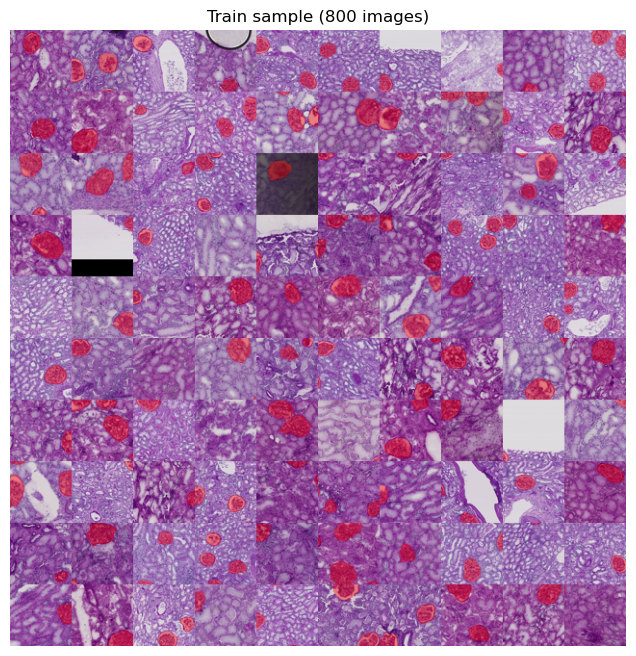

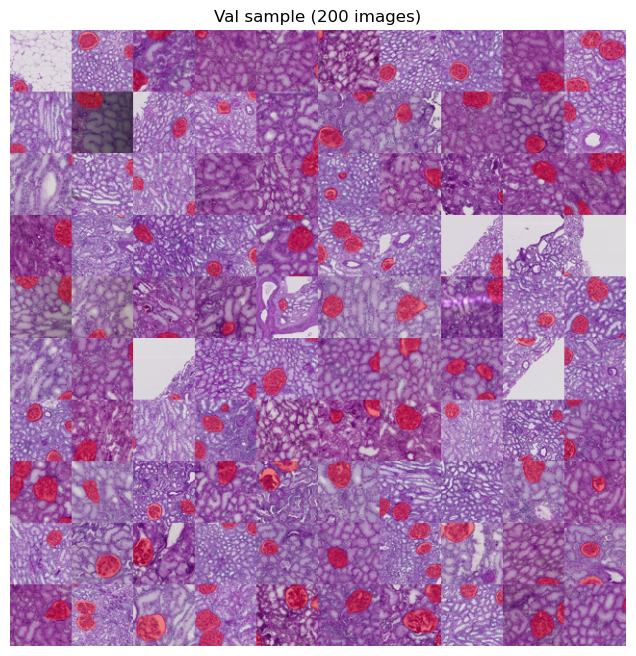

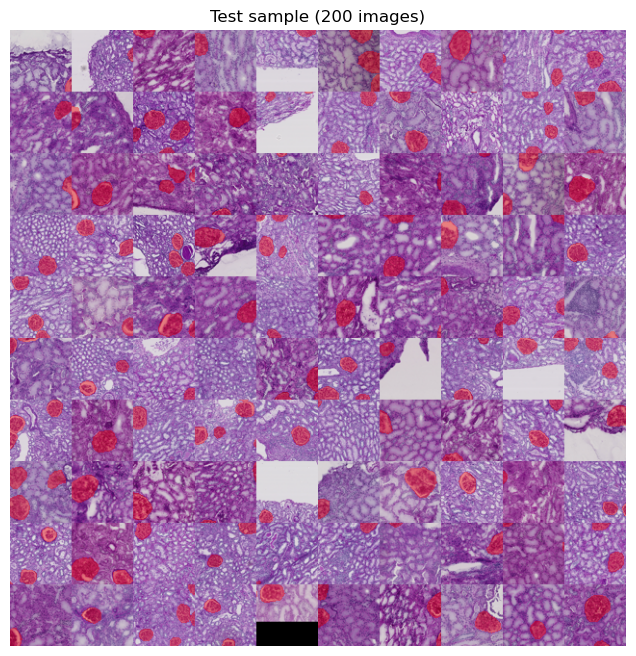

In [7]:
def show_split(split_name, img_list, mask_dir: Path, n_show=100):
    sample = random.sample(img_list, min(n_show, len(img_list)))

    thumbs = [
        overlay_mask(p, mask_dir / f"{p.stem}.png", thumb=64)
        for p in sample
    ]
    sheet = contact_sheet(thumbs, n_cols=10, thumb=64)
    plt.figure(figsize=(8, 8))
    plt.title(f"{split_name} sample ({len(img_list)} images)")
    plt.imshow(sheet)
    plt.axis("off")
    plt.show()

show_split("Train", train_imgs, OUT_MASK["train"])
show_split("Val",   val_imgs,   OUT_MASK["val"])
show_split("Test",  test_imgs,  OUT_MASK["test"])
